In [29]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 

In [9]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import data

In [2]:
df = pd.read_csv("data/daily_min_temp.csv", index_col="Date", parse_dates=["Date"])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


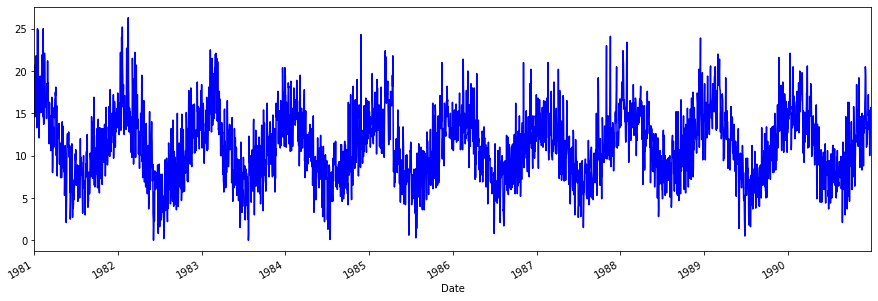

In [4]:
df.Temp.plot(figsize=(15,5), color = "b")

# Dataset Spliting

In [6]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle = False)
ts_train.shape, ts_test.shape

((2920, 1), (730, 1))

# Dataset dan dataloader

In [7]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader 

In [8]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train,"Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test,"Temp",seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



# Arsitektur dan config

In [15]:
class RNN(nn.Module):
    def __init__(self, input_size,output_size, hidden_size, num_layers, dropout):
        super().__init__()
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, dropout = dropout, batch_first =True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x , hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden
        

In [16]:
config = set_config({
    "input_size": train_set.n_feature,
    "seq_len": train_set.n_seq,
    "output_size":1,
    "hidden_size": 64,
    "num_layers": 2,
    "dropout": 0
})

# Training Preparation

In [20]:
model = RNN(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduce="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/rnn")

# Training

In [21]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 128.5208 | Test_cost  = 113.5709 | 




Epoch     2
Train_cost  = 94.0592 | Test_cost  = 83.4103 | 




Epoch     3
Train_cost  = 69.9685 | Test_cost  = 66.2116 | 




Epoch     4
Train_cost  = 56.8627 | Test_cost  = 56.4660 | 




Epoch     5
Train_cost  = 48.9436 | Test_cost  = 49.6910 | 




Epoch     6
Train_cost  = 43.1482 | Test_cost  = 44.2639 | 




Epoch     7
Train_cost  = 38.4205 | Test_cost  = 39.6871 | 




Epoch     8
Train_cost  = 34.4424 | Test_cost  = 35.7938 | 




Epoch     9
Train_cost  = 31.0862 | Test_cost  = 32.4885 | 




Epoch    10
Train_cost  = 28.2664 | Test_cost  = 29.6951 | 




Epoch    11
Train_cost  = 25.9120 | Test_cost  = 27.3473 | 




Epoch    12
Train_cost  = 23.9601 | Test_cost  = 25.3858 | 




Epoch    13
Train_cost  = 22.3542 | Test_cost  = 23.7571 | 




Epoch    14
Train_cost  = 21.0438 | Test_cost  = 22.4133 | 




Epoch    15
Train_cost  = 19.9836 | Test_cost  = 21.3118 | 




Epoch    16
Train_cost  = 19.1334 | Test_cost  = 20.4143 | 




Epoch    17
Train_cost  = 18.4576 | Test_cost  = 19.6875 | 




Epoch    18
Train_cost  = 17.9255 | Test_cost  = 19.1022 | 




Epoch    19
Train_cost  = 17.5101 | Test_cost  = 18.6332 | 




Epoch    20
Train_cost  = 17.1888 | Test_cost  = 18.2591 | 


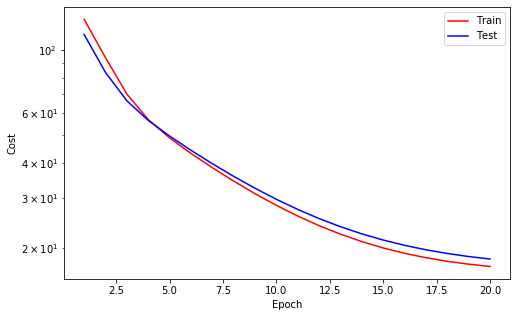



Epoch    21
Train_cost  = 16.9423 | Test_cost  = 17.9617 | 




Epoch    22
Train_cost  = 16.7548 | Test_cost  = 17.7260 | 




Epoch    23
Train_cost  = 16.6130 | Test_cost  = 17.5394 | 




Epoch    24
Train_cost  = 16.5065 | Test_cost  = 17.3919 | 




Epoch    25
Train_cost  = 16.4268 | Test_cost  = 17.2750 | 




Epoch    26
Train_cost  = 16.3671 | Test_cost  = 17.1823 | 




Epoch    27
Train_cost  = 16.3223 | Test_cost  = 17.1083 | 




Epoch    28
Train_cost  = 16.2882 | Test_cost  = 17.0488 | 




Epoch    29
Train_cost  = 16.2617 | Test_cost  = 17.0005 | 




Epoch    30
Train_cost  = 16.2402 | Test_cost  = 16.9604 | 




Epoch    31
Train_cost  = 16.2219 | Test_cost  = 16.9262 | 




Epoch    32
Train_cost  = 16.2048 | Test_cost  = 16.8958 | 




Epoch    33
Train_cost  = 16.1874 | Test_cost  = 16.8671 | 




Epoch    34
Train_cost  = 16.1678 | Test_cost  = 16.8376 | 




Epoch    35
Train_cost  = 16.1433 | Test_cost  = 16.8036 | 




Epoch    36
Train_cost  = 16.1092 | Test_cost  = 16.7579 | 




Epoch    37
Train_cost  = 16.0546 | Test_cost  = 16.6823 | 




Epoch    38
Train_cost  = 15.9491 | Test_cost  = 16.5188 | 




Epoch    39
Train_cost  = 15.6789 | Test_cost  = 16.0296 | 




Epoch    40
Train_cost  = 14.9280 | Test_cost  = 15.2895 | 


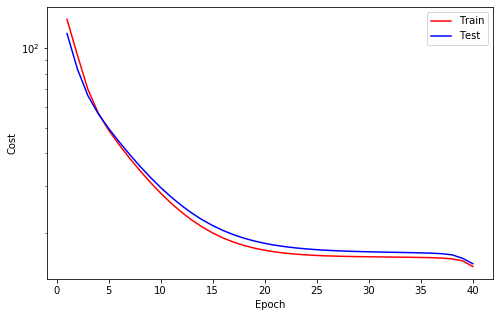



Epoch    41
Train_cost  = 14.0834 | Test_cost  = 14.3557 | 




Epoch    42
Train_cost  = 13.2298 | Test_cost  = 13.6528 | 




Epoch    43
Train_cost  = 12.6350 | Test_cost  = 12.9070 | 




Epoch    44
Train_cost  = 11.9766 | Test_cost  = 12.1290 | 




Epoch    45
Train_cost  = 11.3898 | Test_cost  = 11.4643 | 




Epoch    46
Train_cost  = 10.9070 | Test_cost  = 10.8923 | 




Epoch    47
Train_cost  = 10.4822 | Test_cost  = 10.4295 | 




Epoch    48
Train_cost  = 10.1435 | Test_cost  = 10.0057 | 




Epoch    49
Train_cost  = 9.8300 | Test_cost  = 9.6240 | 




Epoch    50
Train_cost  = 9.5319 | Test_cost  = 9.2904 | 




Epoch    51
Train_cost  = 9.2817 | Test_cost  = 8.9951 | 




Epoch    52
Train_cost  = 9.0740 | Test_cost  = 8.7290 | 




Epoch    53
Train_cost  = 8.8872 | Test_cost  = 8.4915 | 




Epoch    54
Train_cost  = 8.7141 | Test_cost  = 8.2813 | 




Epoch    55
Train_cost  = 8.5598 | Test_cost  = 8.0937 | 




Epoch    56
Train_cost  = 8.4228 | Test_cost  = 7.9228 | 




Epoch    57
Train_cost  = 8.2950 | Test_cost  = 7.7654 | 




Epoch    58
Train_cost  = 8.1733 | Test_cost  = 7.6217 | 




Epoch    59
Train_cost  = 8.0604 | Test_cost  = 7.4911 | 




Epoch    60
Train_cost  = 7.9571 | Test_cost  = 7.3713 | 


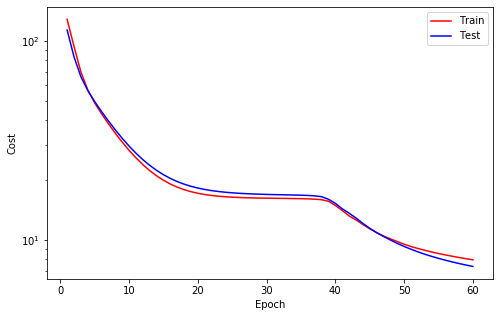



Epoch    61
Train_cost  = 7.8617 | Test_cost  = 7.2605 | 




Epoch    62
Train_cost  = 7.7729 | Test_cost  = 7.1584 | 




Epoch    63
Train_cost  = 7.6909 | Test_cost  = 7.0648 | 




Epoch    64
Train_cost  = 7.6157 | Test_cost  = 6.9786 | 




Epoch    65
Train_cost  = 7.5469 | Test_cost  = 6.8988 | 




Epoch    66
Train_cost  = 7.4837 | Test_cost  = 6.8246 | 




Epoch    67
Train_cost  = 7.4253 | Test_cost  = 6.7551 | 




Epoch    68
Train_cost  = 7.3709 | Test_cost  = 6.6898 | 




Epoch    69
Train_cost  = 7.3202 | Test_cost  = 6.6284 | 




Epoch    70
Train_cost  = 7.2728 | Test_cost  = 6.5703 | 




Epoch    71
Train_cost  = 7.2283 | Test_cost  = 6.5154 | 




Epoch    72
Train_cost  = 7.1863 | Test_cost  = 6.4634 | 




Epoch    73
Train_cost  = 7.1467 | Test_cost  = 6.4141 | 




Epoch    74
Train_cost  = 7.1091 | Test_cost  = 6.3674 | 




Epoch    75
Train_cost  = 7.0735 | Test_cost  = 6.3231 | 




Epoch    76
Train_cost  = 7.0396 | Test_cost  = 6.2811 | 




Epoch    77
Train_cost  = 7.0074 | Test_cost  = 6.2412 | 




Epoch    78
Train_cost  = 6.9767 | Test_cost  = 6.2034 | 




Epoch    79
Train_cost  = 6.9476 | Test_cost  = 6.1674 | 




Epoch    80
Train_cost  = 6.9198 | Test_cost  = 6.1332 | 


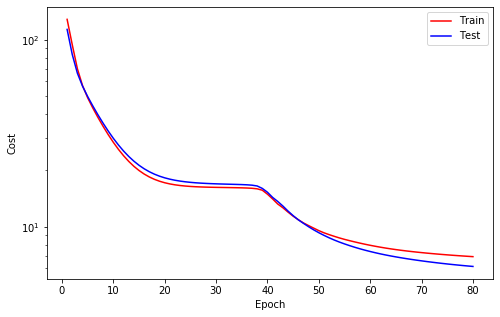



Epoch    81
Train_cost  = 6.8933 | Test_cost  = 6.1007 | 




Epoch    82
Train_cost  = 6.8680 | Test_cost  = 6.0697 | 




Epoch    83
Train_cost  = 6.8438 | Test_cost  = 6.0401 | 




Epoch    84
Train_cost  = 6.8207 | Test_cost  = 6.0119 | 




Epoch    85
Train_cost  = 6.7985 | Test_cost  = 5.9849 | 




Epoch    86
Train_cost  = 6.7773 | Test_cost  = 5.9591 | 




Epoch    87
Train_cost  = 6.7570 | Test_cost  = 5.9345 | 




Epoch    88
Train_cost  = 6.7376 | Test_cost  = 5.9109 | 




Epoch    89
Train_cost  = 6.7190 | Test_cost  = 5.8883 | 




Epoch    90
Train_cost  = 6.7011 | Test_cost  = 5.8666 | 




Epoch    91
Train_cost  = 6.6839 | Test_cost  = 5.8457 | 




Epoch    92
Train_cost  = 6.6675 | Test_cost  = 5.8257 | 




Epoch    93
Train_cost  = 6.6517 | Test_cost  = 5.8063 | 




Epoch    94
Train_cost  = 6.6365 | Test_cost  = 5.7877 | 




Epoch    95
Train_cost  = 6.6218 | Test_cost  = 5.7698 | 




Epoch    96
Train_cost  = 6.6077 | Test_cost  = 5.7524 | 




Epoch    97
Train_cost  = 6.5941 | Test_cost  = 5.7356 | 




Epoch    98
Train_cost  = 6.5810 | Test_cost  = 5.7194 | 




Epoch    99
Train_cost  = 6.5683 | Test_cost  = 5.7036 | 




Epoch   100
Train_cost  = 6.5561 | Test_cost  = 5.6884 | 


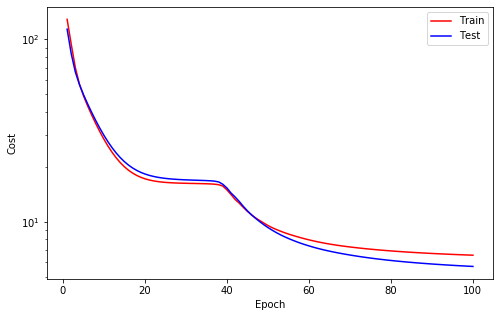



Epoch   101
Train_cost  = 6.5442 | Test_cost  = 5.6736 | 




Epoch   102
Train_cost  = 6.5327 | Test_cost  = 5.6592 | 




Epoch   103
Train_cost  = 6.5216 | Test_cost  = 5.6453 | 




Epoch   104
Train_cost  = 6.5108 | Test_cost  = 5.6318 | 




Epoch   105
Train_cost  = 6.5003 | Test_cost  = 5.6186 | 




Epoch   106
Train_cost  = 6.4901 | Test_cost  = 5.6058 | 




Epoch   107
Train_cost  = 6.4802 | Test_cost  = 5.5934 | 




Epoch   108
Train_cost  = 6.4706 | Test_cost  = 5.5813 | 




Epoch   109
Train_cost  = 6.4612 | Test_cost  = 5.5696 | 




Epoch   110
Train_cost  = 6.4521 | Test_cost  = 5.5581 | 




Epoch   111
Train_cost  = 6.4432 | Test_cost  = 5.5470 | 




Epoch   112
Train_cost  = 6.4346 | Test_cost  = 5.5362 | 




Epoch   113
Train_cost  = 6.4261 | Test_cost  = 5.5256 | 




Epoch   114
Train_cost  = 6.4179 | Test_cost  = 5.5153 | 




Epoch   115
Train_cost  = 6.4098 | Test_cost  = 5.5053 | 




Epoch   116
Train_cost  = 6.4020 | Test_cost  = 5.4956 | 




Epoch   117
Train_cost  = 6.3943 | Test_cost  = 5.4861 | 




Epoch   118
Train_cost  = 6.3868 | Test_cost  = 5.4768 | 




Epoch   119
Train_cost  = 6.3794 | Test_cost  = 5.4678 | 




Epoch   120
Train_cost  = 6.3723 | Test_cost  = 5.4590 | 


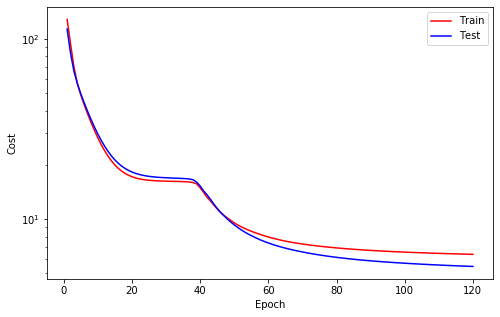



Epoch   121
Train_cost  = 6.3652 | Test_cost  = 5.4505 | 




Epoch   122
Train_cost  = 6.3583 | Test_cost  = 5.4421 | 




Epoch   123
Train_cost  = 6.3516 | Test_cost  = 5.4340 | 




Epoch   124
Train_cost  = 6.3450 | Test_cost  = 5.4260 | 




Epoch   125
Train_cost  = 6.3385 | Test_cost  = 5.4183 | 




Epoch   126
Train_cost  = 6.3322 | Test_cost  = 5.4108 | 




Epoch   127
Train_cost  = 6.3260 | Test_cost  = 5.4034 | 




Epoch   128
Train_cost  = 6.3199 | Test_cost  = 5.3962 | 




Epoch   129
Train_cost  = 6.3139 | Test_cost  = 5.3893 | 




Epoch   130
Train_cost  = 6.3080 | Test_cost  = 5.3825 | 




Epoch   131
Train_cost  = 6.3022 | Test_cost  = 5.3758 | 




Epoch   132
Train_cost  = 6.2966 | Test_cost  = 5.3694 | 




Epoch   133
Train_cost  = 6.2910 | Test_cost  = 5.3631 | 




Epoch   134
Train_cost  = 6.2856 | Test_cost  = 5.3569 | 




Epoch   135
Train_cost  = 6.2802 | Test_cost  = 5.3510 | 




Epoch   136
Train_cost  = 6.2749 | Test_cost  = 5.3452 | 




Epoch   137
Train_cost  = 6.2697 | Test_cost  = 5.3395 | 




Epoch   138
Train_cost  = 6.2647 | Test_cost  = 5.3340 | 




Epoch   139
Train_cost  = 6.2596 | Test_cost  = 5.3286 | 




Epoch   140
Train_cost  = 6.2547 | Test_cost  = 5.3234 | 


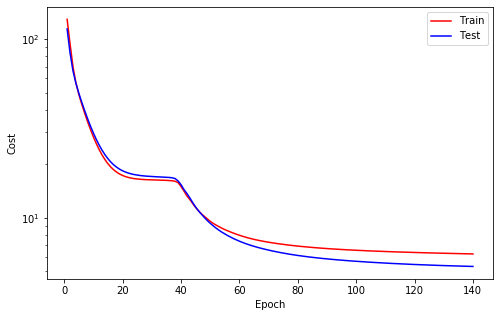



Epoch   141
Train_cost  = 6.2499 | Test_cost  = 5.3184 | 




Epoch   142
Train_cost  = 6.2451 | Test_cost  = 5.3134 | 




Epoch   143
Train_cost  = 6.2404 | Test_cost  = 5.3086 | 




Epoch   144
Train_cost  = 6.2358 | Test_cost  = 5.3040 | 




Epoch   145
Train_cost  = 6.2312 | Test_cost  = 5.2995 | 




Epoch   146
Train_cost  = 6.2267 | Test_cost  = 5.2951 | 




Epoch   147
Train_cost  = 6.2223 | Test_cost  = 5.2909 | 




Epoch   148
Train_cost  = 6.2179 | Test_cost  = 5.2868 | 




Epoch   149
Train_cost  = 6.2136 | Test_cost  = 5.2828 | 




Epoch   150
Train_cost  = 6.2093 | Test_cost  = 5.2789 | 




Epoch   151
Train_cost  = 6.2051 | Test_cost  = 5.2752 | 




Epoch   152
Train_cost  = 6.2009 | Test_cost  = 5.2716 | 




Epoch   153
Train_cost  = 6.1968 | Test_cost  = 5.2681 | 




Epoch   154
Train_cost  = 6.1927 | Test_cost  = 5.2647 | 




Epoch   155
Train_cost  = 6.1887 | Test_cost  = 5.2615 | 




Epoch   156
Train_cost  = 6.1847 | Test_cost  = 5.2584 | 




Epoch   157
Train_cost  = 6.1808 | Test_cost  = 5.2554 | 




Epoch   158
Train_cost  = 6.1769 | Test_cost  = 5.2525 | 




Epoch   159
Train_cost  = 6.1730 | Test_cost  = 5.2497 | 




Epoch   160
Train_cost  = 6.1692 | Test_cost  = 5.2470 | 


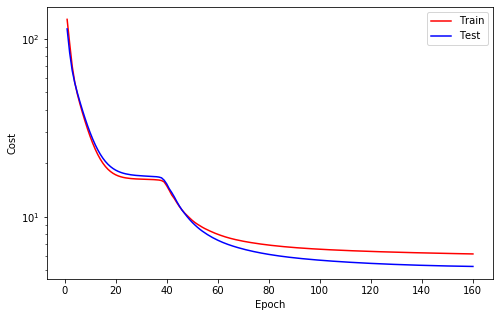



Epoch   161
Train_cost  = 6.1654 | Test_cost  = 5.2445 | 




Epoch   162
Train_cost  = 6.1616 | Test_cost  = 5.2420 | 




Epoch   163
Train_cost  = 6.1578 | Test_cost  = 5.2397 | 




Epoch   164
Train_cost  = 6.1541 | Test_cost  = 5.2375 | 




Epoch   165
Train_cost  = 6.1505 | Test_cost  = 5.2354 | 




Epoch   166
Train_cost  = 6.1468 | Test_cost  = 5.2333 | 




Epoch   167
Train_cost  = 6.1432 | Test_cost  = 5.2314 | 




Epoch   168
Train_cost  = 6.1396 | Test_cost  = 5.2296 | 




Epoch   169
Train_cost  = 6.1360 | Test_cost  = 5.2279 | 




Epoch   170
Train_cost  = 6.1324 | Test_cost  = 5.2262 | 




Epoch   171
Train_cost  = 6.1289 | Test_cost  = 5.2247 | 




Epoch   172
Train_cost  = 6.1254 | Test_cost  = 5.2232 | 




Epoch   173
Train_cost  = 6.1219 | Test_cost  = 5.2219 | 




Epoch   174
Train_cost  = 6.1185 | Test_cost  = 5.2206 | 




Epoch   175
Train_cost  = 6.1150 | Test_cost  = 5.2194 | 




Epoch   176
Train_cost  = 6.1116 | Test_cost  = 5.2183 | 




Epoch   177
Train_cost  = 6.1082 | Test_cost  = 5.2172 | 




Epoch   178
Train_cost  = 6.1048 | Test_cost  = 5.2162 | 




Epoch   179
Train_cost  = 6.1015 | Test_cost  = 5.2153 | 




Epoch   180
Train_cost  = 6.0981 | Test_cost  = 5.2145 | 


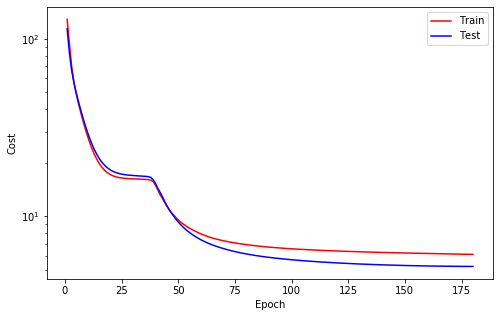



Epoch   181
Train_cost  = 6.0948 | Test_cost  = 5.2137 | 




Epoch   182
Train_cost  = 6.0915 | Test_cost  = 5.2130 | 




Epoch   183
Train_cost  = 6.0883 | Test_cost  = 5.2123 | 




Epoch   184
Train_cost  = 6.0850 | Test_cost  = 5.2117 | 




Epoch   185
Train_cost  = 6.0818 | Test_cost  = 5.2112 | 




Epoch   186
Train_cost  = 6.0786 | Test_cost  = 5.2106 | 




Epoch   187
Train_cost  = 6.0754 | Test_cost  = 5.2102 | 




Epoch   188
Train_cost  = 6.0722 | Test_cost  = 5.2097 | 




Epoch   189
Train_cost  = 6.0690 | Test_cost  = 5.2094 | 




Epoch   190
Train_cost  = 6.0658 | Test_cost  = 5.2090 | 




Epoch   191
Train_cost  = 6.0627 | Test_cost  = 5.2087 | 




Epoch   192
Train_cost  = 6.0595 | Test_cost  = 5.2084 | 




Epoch   193
Train_cost  = 6.0564 | Test_cost  = 5.2082 | 




Epoch   194
Train_cost  = 6.0532 | Test_cost  = 5.2080 | 




Epoch   195
Train_cost  = 6.0501 | Test_cost  = 5.2078 | 




Epoch   196
Train_cost  = 6.0470 | Test_cost  = 5.2077 | 




Epoch   197
Train_cost  = 6.0439 | Test_cost  = 5.2076 | 




Epoch   198
Train_cost  = 6.0408 | Test_cost  = 5.2076 | 




Epoch   199
Train_cost  = 6.0376 | Test_cost  = 5.2075 | 




Epoch   200
Train_cost  = 6.0345 | Test_cost  = 5.2075 | 


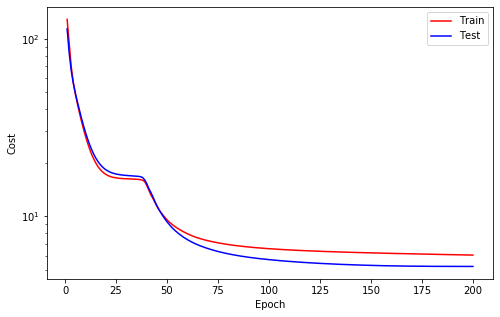

==> EarlyStop patience =  1 | Best test_cost: 5.2075




Epoch   201
Train_cost  = 6.0314 | Test_cost  = 5.2076 | 
==> EarlyStop patience =  2 | Best test_cost: 5.2075




Epoch   202
Train_cost  = 6.0282 | Test_cost  = 5.2077 | 
==> EarlyStop patience =  3 | Best test_cost: 5.2075




Epoch   203
Train_cost  = 6.0251 | Test_cost  = 5.2078 | 
==> EarlyStop patience =  4 | Best test_cost: 5.2075




Epoch   204
Train_cost  = 6.0219 | Test_cost  = 5.2080 | 
==> EarlyStop patience =  5 | Best test_cost: 5.2075
==> Execute Early Stopping at epoch: 204 | Best test_cost: 5.2075
==> Best model is saved at model/rnn


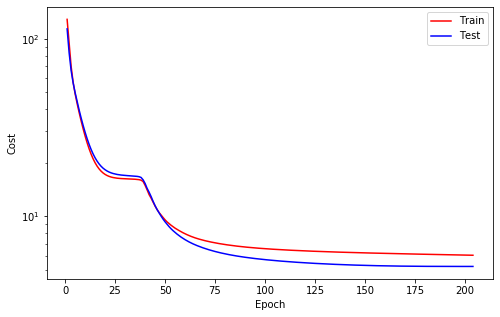

In [22]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Sanity Check

In [23]:
from luwiji.rnn import illustration

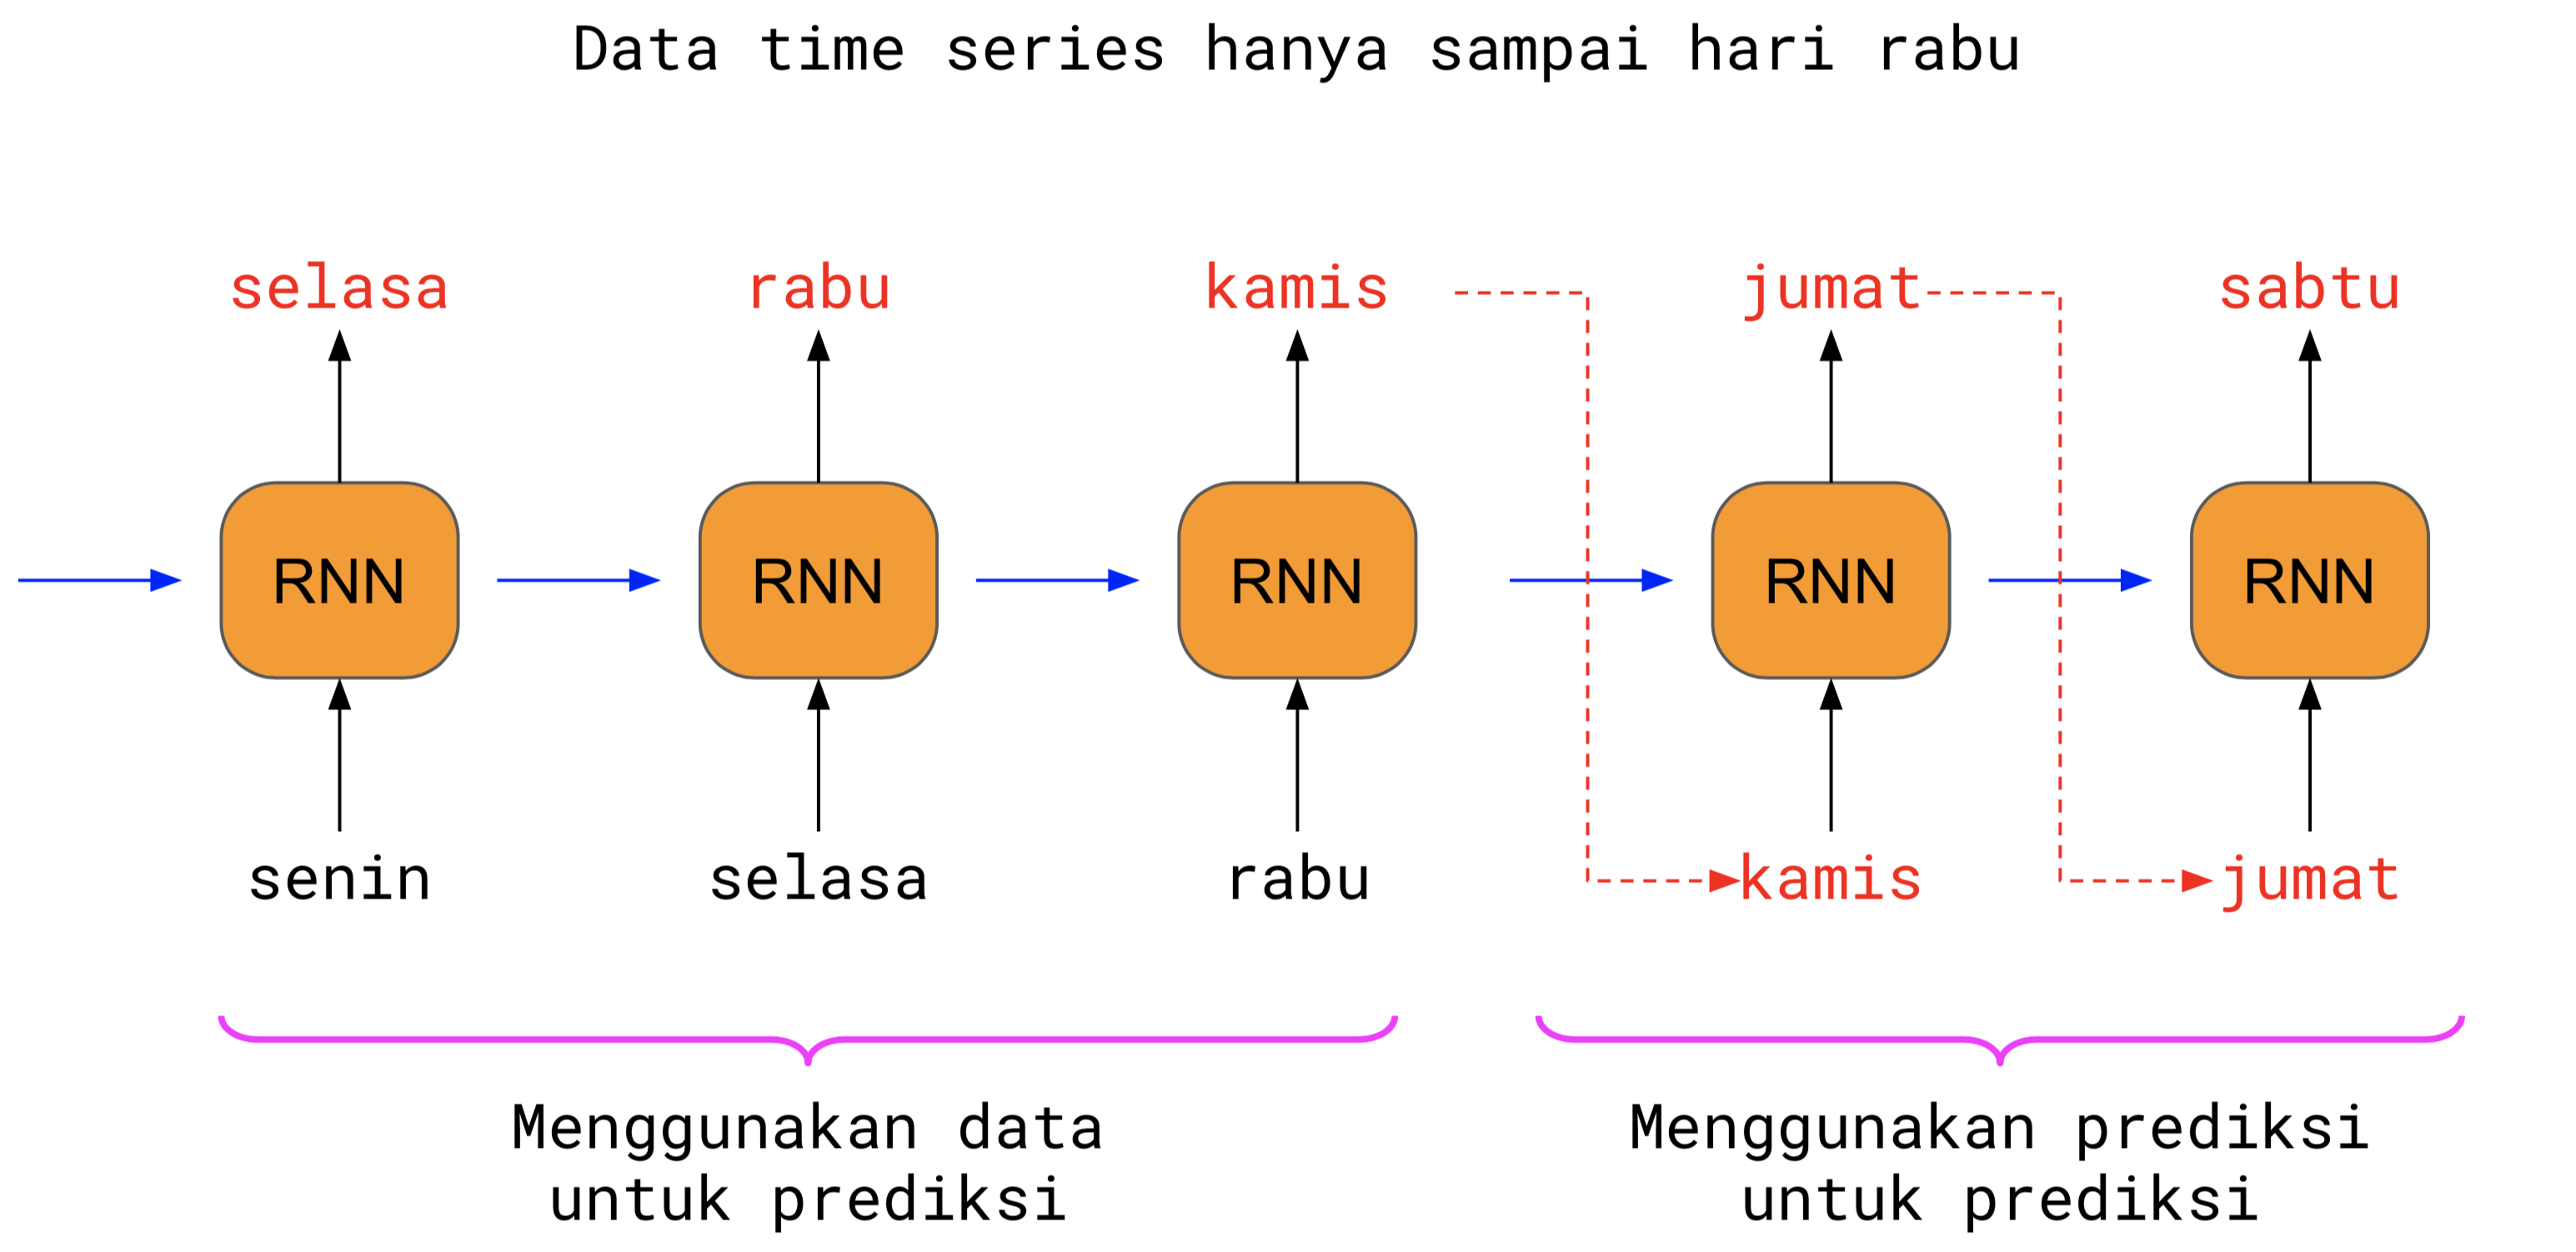

In [24]:
illustration.forecast

In [27]:
from utils import data4pred, pred4pred

In [28]:
train_forecast_set =TimeSeriesDataset(ts_train,"Temp",1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set =TimeSeriesDataset(ts_test,"Temp",1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



# Visualization

Text(0.5, 1.0, 'Test')

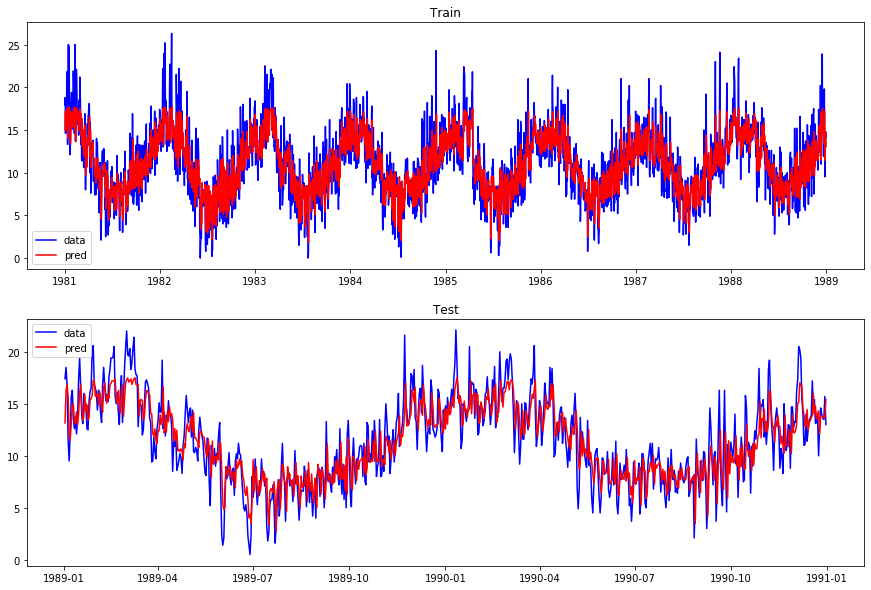

In [30]:
#data 4 pred
plt.figure(figsize=(15,10))

plt.subplot(211)
data4pred(model,train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model,test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'Test')

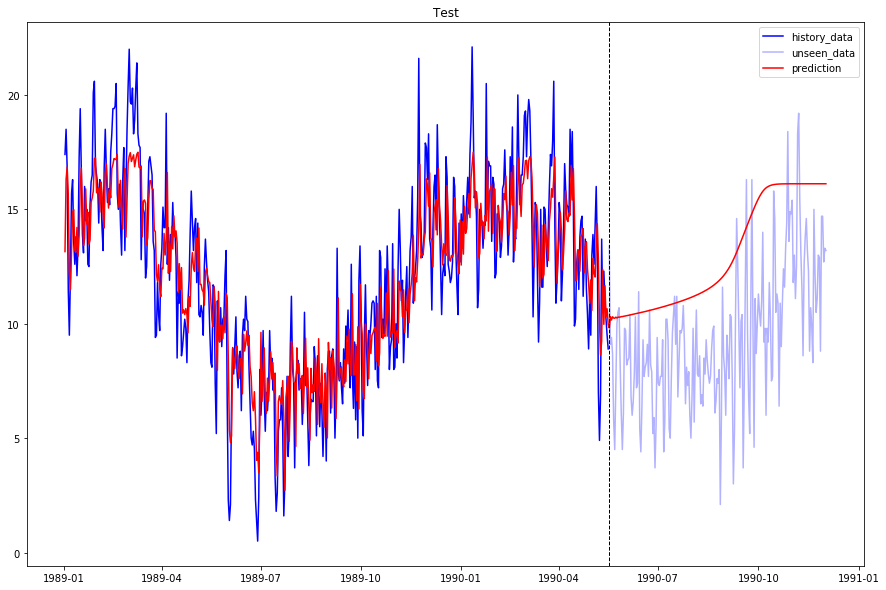

In [31]:
#pred 4 pred
plt.figure(figsize=(15,10))
pred4pred(model,test_forecast_set, testforecastloader, device)
plt.title("Test")